In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV

In [45]:
df = pd.read_csv('titanic.csv')

**Descripciones de las columnas:**

**PassengerId**: Identificación única para cada pasajero.

**Survived**: Indica si el pasajero sobrevivió al naufragio (0 = No, 1 = Sí).

**Pclass**: Clase del boleto (1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase).

**Name**: Nombre del pasajero.

**Sex**: Género del pasajero.

**Age**: Edad del pasajero.

**SibSp**: Número de hermanos/cónyuges a bordo del Titanic.

**Parch**: Número de padres/hijos a bordo del Titanic.

**Ticket**: Número del boleto.

**Fare**: Tarifa pagada por el pasajero.

**Cabin**: Número de cabina.

**Embarked**: Puerto de embarque (C = Cherbourg, Q = Queenstown, S = Southampton).

In [46]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
df.shape

(891, 12)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [49]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<span style='color:peru'> Estaría bueno agregar el análisis de balance de positivos y negativos en target (survived) ya que eso permitira o no obtener una curva ROC más "suave y completa" ya que habrá más umbrales significativos. OJO esta es conclusion mía que puede estar mal o no tomarlo con pinzas. Ver al último y comparar con el caso de clase en donde esta muy desbalanceado.  
En este caso esta muy bien balanceado, va a dar una curva ROC "suave y completa" (muchos puntos).</span>

In [50]:
print(f'Balance {df.Survived.value_counts()}')
print(f'Balance en % {df.Survived.value_counts(normalize=True)}')

Balance Survived
0    549
1    342
Name: count, dtype: int64
Balance en % Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


**Pasajeros que no pagaron nada por clase**

In [51]:
# Contar cuántos pasajeros tienen una tarifa igual a 0 por cada clase
count_zero_fare_by_pclass = df[df['Fare'] == 0].groupby('Pclass').size()

# Mostrar los resultados
print("Cantidad de pasajeros que no pagaron por clase:")
print(count_zero_fare_by_pclass)

Cantidad de pasajeros que no pagaron por clase:
Pclass
1    5
2    6
3    4
dtype: int64


**Reemplazo a los que no pagaron con la media de acuerdo a su pclass**

In [52]:
# Calcular la media de tarifas para cada Pclass
mean_fare_by_pclass = df.groupby('Pclass')['Fare'].mean()

# Función para reemplazar valores de tarifa de 0 con la media de su Pclass
def replace_zero_fare(row):
    if row['Fare'] == 0:
        return mean_fare_by_pclass[row['Pclass']]
    else:
        return row['Fare']

# Aplicar la función a la columna 'Fare'
df['Fare'] = df.apply(replace_zero_fare, axis=1)

In [53]:
# Otra forma (aunque para df grandes, sería mejor la anterior)
# df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.replace(0, x.mean()))

# Otra forma que es como la primera pero mas compacta.
# Calcula la media por cada clase y crea un diccionario de mapeo
# mean_Pclass = df.groupby('Pclass')['Fare'].mean().to_dict()
# Reemplaza los valores cero en la columna 'Fare' con la media correspondiente de su clase
# df['Fare'] = df.apply(lambda row: mean_Pclass[row['Pclass']] if row['Fare'] == 0 else row['Fare'], axis=1)

In [54]:
# Verificar que los valores de tarifa de 0 se han reemplazado
print(df[df['Fare'] == 0])

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


In [55]:
min_max_fare = df.groupby('Pclass')['Fare'].agg(['min', 'max'])
min_max_fare

,min,max
Pclass,,
1,5.0000,512.3292
2,10.5000,73.5000
3,4.0125,69.5500


In [56]:
describe_by_pclass_fare = df.groupby('Pclass')['Fare'].describe().round(0)
describe_by_pclass_fare

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,86.0,77.0,5.0,34.0,67.0,94.0,512.0
2,184.0,21.0,13.0,10.0,13.0,16.0,26.0,74.0
3,491.0,14.0,12.0,4.0,8.0,8.0,16.0,70.0


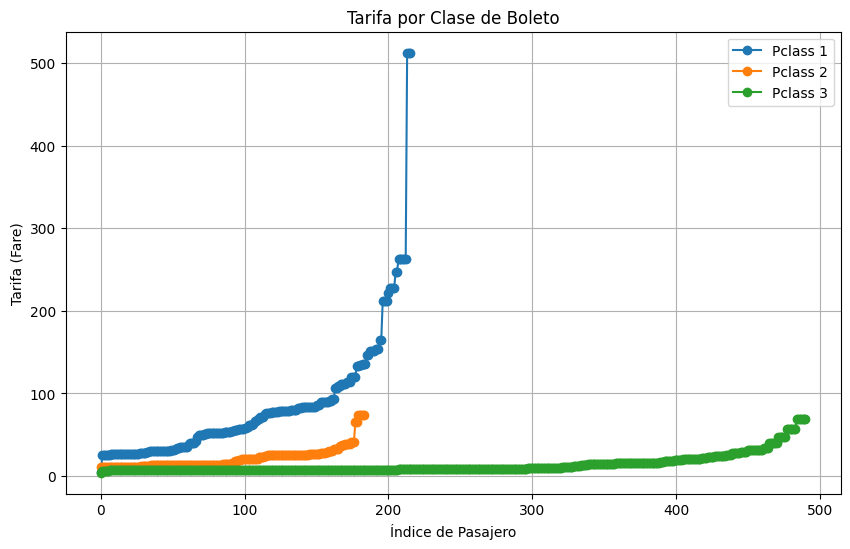

In [57]:
# Ordenar el DataFrame por Pclass y Fare
df_sorted = df.sort_values(by=['Pclass', 'Fare'])

# Crear un gráfico de líneas para visualizar la relación entre Fare y Pclass
plt.figure(figsize=(10, 6))

for pclass, group_df in df_sorted.groupby('Pclass'):
    plt.plot(group_df['Fare'].values, label=f'Pclass {pclass}', marker='o', linestyle='-')

plt.title('Tarifa por Clase de Boleto')
plt.xlabel('Índice de Pasajero')
plt.ylabel('Tarifa (Fare)')
plt.legend()
plt.grid(True)
plt.show()

# Muy bueno, pero yo aclararía el término "Indice de pasajero" como la tarifa que paga cada pasajero por su clase 
# (por alguna razón no son iguales o uniforme, debe haber extras o aditivos).

**Analisis de la Columna Age**

In [58]:
df["Age"].isna().sum()

177

In [59]:
describe_by_pclass_rounded = df.groupby('Pclass')['Age'].describe().round(0)
describe_by_pclass_rounded

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,186.0,38.0,15.0,1.0,27.0,37.0,49.0,80.0
2,173.0,30.0,14.0,1.0,23.0,29.0,36.0,70.0
3,355.0,25.0,12.0,0.0,18.0,24.0,32.0,74.0


In [60]:
#Cantidad de Age nulos de acuerdo a su Pclass
nan_age_counts = df[df['Age'].isna()].groupby('Pclass').size()
nan_age_counts

Pclass
1     30
2     11
3    136
dtype: int64

In [61]:
#Edad promedio de los pasajeros de acuerdo a su pclass
mean_age_by_pclass = df.groupby('Pclass')['Age'].mean().round(0)
mean_age_by_pclass

Pclass
1    38.0
2    30.0
3    25.0
Name: Age, dtype: float64

In [62]:
#Edad minima y maxima de los pasajeros de acuerdo a su pclass
min_max_fare = df.groupby('Pclass')['Age'].agg(['min', 'max'])
min_max_fare

,min,max
Pclass,,
1,0.92,80.0
2,0.67,70.0
3,0.42,74.0


**Imputacion de los valores faltantes tomando en cuenta el promedio de edad de pasajeros de la misma clase o género**

In [63]:
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.mean()))

In [64]:
df["Age"].isna().sum()

0

In [65]:
describe_by_pclass_rounded = df.groupby('Pclass')['Age'].describe().round(0)
describe_by_pclass_rounded

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,38.0,14.0,1.0,29.0,38.0,47.0,80.0
2,184.0,30.0,14.0,1.0,23.0,30.0,36.0,70.0
3,491.0,25.0,11.0,0.0,20.0,26.0,29.0,74.0


In [66]:
#Edad minima y maxima de los pasajeros de acuerdo a su pclass
min_max_fare = df.groupby('Pclass')['Age'].agg(['min', 'max'])
min_max_fare

,min,max
Pclass,,
1,0.92,80.0
2,0.67,70.0
3,0.42,74.0


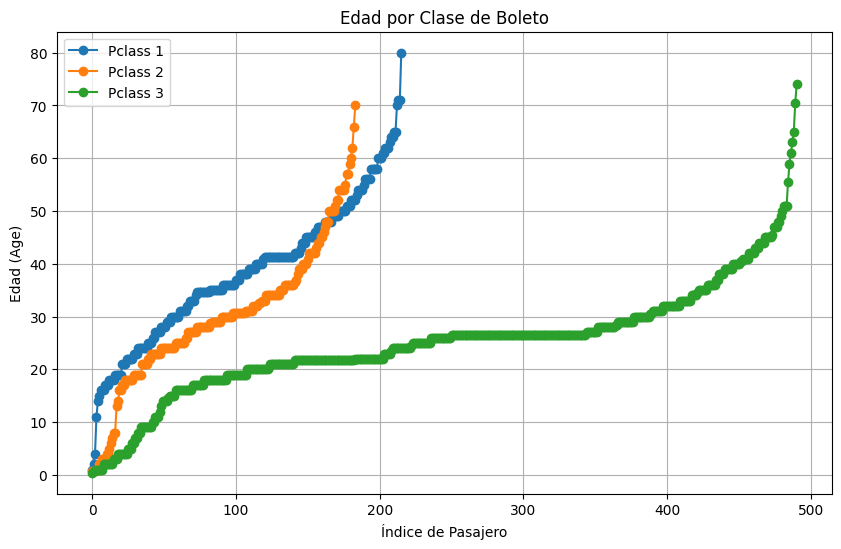

In [67]:
# Ordenar el DataFrame por Pclass y Age
df_sorted = df.sort_values(by=['Pclass', 'Age'])

# Crear un gráfico de líneas para visualizar la relación entre Age y Pclass
plt.figure(figsize=(10, 6))

for pclass, group_df in df_sorted.groupby('Pclass'):
    plt.plot(group_df['Age'].values, label=f'Pclass {pclass}', marker='o', linestyle='-')

plt.title('Edad por Clase de Boleto')
plt.xlabel('Índice de Pasajero')
plt.ylabel('Edad (Age)')
plt.legend()
plt.grid(True)
plt.show()

**Dropeo de columnas que no se utilizaran para el analisis**

In [68]:
df.drop(["PassengerId","Name","Ticket","Cabin","Embarked","SibSp","Parch"], axis=1, inplace= True)

In [69]:
df.head(5)

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


**Como tenemos variables categoricas en Sex utilizamos un One hot enconder**

In [70]:
# Aplicar One-Hot Encoder
encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[['Sex']])

# Convertir el resultado a un DataFrame y unirlo con el DataFrame original
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['Sex']))
df = pd.concat([df, encoded_df], axis=1)

**Para evitar la multicolinealidad (una situación en la que las variables predictoras están altamente correlacionadas) eliminamos la columna Sex_male** 

In [71]:
df = df.drop(['Sex_male'], axis=1)

**Eliminamos la columna Sex**

In [72]:
df = df.drop(['Sex'], axis=1)

In [73]:
# Fijensé que las tres celdas anteriores se podrían haber evitado simplemente con: (sin utilizar onehotencoder)
# df['Sex'] = df['Sex'].replace({'female': 0., 'male': 1.})

In [74]:
df.head(5)

,Survived,Pclass,Age,Fare,Sex_female
0,0,3,22.0,7.2500,0.0
1,1,1,38.0,71.2833,1.0
2,1,3,26.0,7.9250,1.0
3,1,1,35.0,53.1000,1.0
4,0,3,35.0,8.0500,0.0


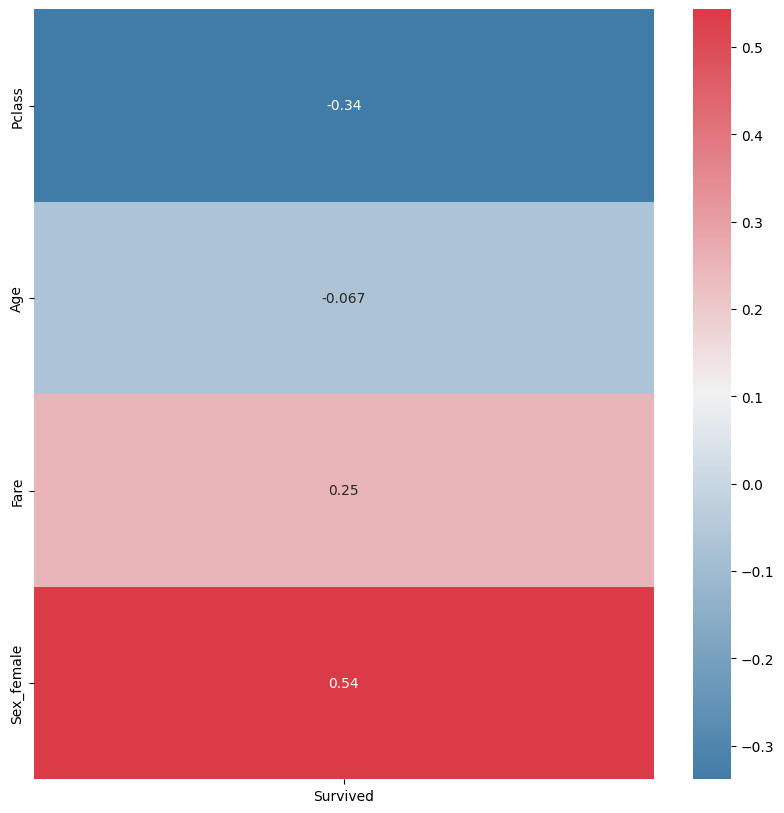

In [75]:
# Calcular la correlación excluyendo la variable objetivo consigo misma
target_corr = pd.DataFrame(df.corr()['Survived'].drop('Survived'), index=df.corr().index.drop('Survived'))

# Crear un mapa de calor
cmap = sns.diverging_palette(240, 10, as_cmap=True)
plt.figure(figsize=(10, 10))
sns.heatmap(target_corr, annot=True, cmap=cmap)

plt.show()

<span style='color:peru'>Despues de hacer esto, recién hubiera descartado variables no antes. Porque por ejemplo age tiene poca correlación y sib y parch ahora no puedo saberlo porque se eliminó antes.</span>

# Definimos nuestro x e y

In [76]:
X = df.drop(columns = ['Survived'])
y = df['Survived']

### Primer caso Decision Tree Classifier utilizando Crossvalidation
<span style='color:peru'>Nota: Crossvalidation es ajustar o entrenar un modelo particionando Xtrain en un número establecido cv rotar la validacion y promediar.  
La función principal de GridSearch no es crossvalidation sino que es optimizar los hiperparámetros del modelo en cuestion.Para cada valor propuesto del hiperparámetro va calculando el score y busca maximizar o minimizar ese score (depende del score). Para el cálculo utiliza crossvalidation pero tambien utliliza Stratify por ejemplo, pero su funcion principal es optimizar los hiperparámetros, no hacer cross validation.</span>

<span style='color:peru'>Antes de todo deberían haber separado en Xtrain y Xtest y recién haber optimizado con Xtrain.
Siempre hay que dejar Xtest e ytest aparte para no meter ningún tipo informacion en el modelo ajustado.   
Con ytest se quiere simular el error que le daría al modelo cuando se enfrente a datos nuevos, la mejor forma es apartarlo desde un comienzo. Asi que en todo lo que sigue yo hubiera trabajado con Xtrain e ytrain</span>

In [77]:
# Inicializar el modelo de árbol de decisión
model = DecisionTreeClassifier()

# Crear un pipeline que incluya el escalado y el modelo
tree_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("decision_tree", model)
])

# Definir los hiperparámetros a ajustar y sus posibles valores
param_grid = {
    'decision_tree__max_depth': [1, 2, 3, 4, 5],  # Valores de max_depth a probar
    'decision_tree__min_samples_split': [2, 3, 4, 5],  # Valores de min_samples_split a probar
    'decision_tree__min_samples_leaf': [1, 2, 3, 4, 5]  # Valores de min_samples_leaf a probard
}

# Realizar la búsqueda de hiperparámetros mediante GridSearchCV
grid_search = GridSearchCV(tree_pipe, param_grid=param_grid, cv=5, scoring='accuracy')

# Ajustar el modelo a los datos
grid_search.fit(X, y)

# Imprimir los mejores hiperparámetros y su precisión asociada
best_params = grid_search.best_params_
best_score = round(grid_search.best_score_, 2)

print("Mejores hiperparámetros:", best_params)
print("Precisión con mejores hiperparámetros:", best_score)

Mejores hiperparámetros: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_leaf': 1, 'decision_tree__min_samples_split': 2}
Precisión con mejores hiperparámetros: 0.81


<span style='color:peru'>Aca se debe separar Xtrain de Xtest, NO hay que entrenar con todo df. Porque sino se quedan sin poder probarlo, además de que no puede generalizarse el modelo.</span>  


In [78]:
# Inicializar el modelo de árbol de decisión con los mejores hiperparámetros
best_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=2
)

# Crear un pipeline que incluya el escalado y el modelo
best_tree_pipe = Pipeline([
    ("scaler", StandardScaler()),  # Puedes omitir esto si no crees que el escalado sea necesario
    ("decision_tree", best_model)
])

# Entrenar el modelo con todos los datos
best_tree_pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('decision_tree', DecisionTreeClassifier(max_depth=5))])

In [79]:
# Realizar la validación cruzada de 5 pliegues
cross_val_scores_best_model = cross_val_score(best_tree_pipe, X, y, cv=5, scoring='accuracy')

# Imprimir la media y la desviación estándar de las puntuaciones de validación cruzada
print(f"Media: {round(cross_val_scores_best_model.mean(), 2)}")
print(f"Desviación Estándar: {round(cross_val_scores_best_model.std(), 2)}")

Media: 0.81
Desviación Estándar: 0.02


**Probabilidades Positivas**

<span style='color:peru'> Aca se deberían haber utilizado Xtest e ytest para calcular ROC y roc_auc.   
Porque de otro modo se están prediciendo valores que fueron utilizados para ajustar el modelo "y".  
O sea en y_probabilities ya existe información de "y" (del modo en que lo hicieron), y eso no debe ocurrir, porque cuando utilicemos el modelo para datos nuevos de hecho no va a ocurrir. </span>  
 <span style='color:peru'>Es cierto que algunos lo hacen con Xtrain e ytrain para caracterizar el modelo, pero yo no estoy de acuerdo para mi no sirve de nada, porque no generaliza el modelo.   
 Lo que si no he visto es que se haga con el df completo eso si me parece está mal; porque sino nos quedamos sin datos para probar.</span>

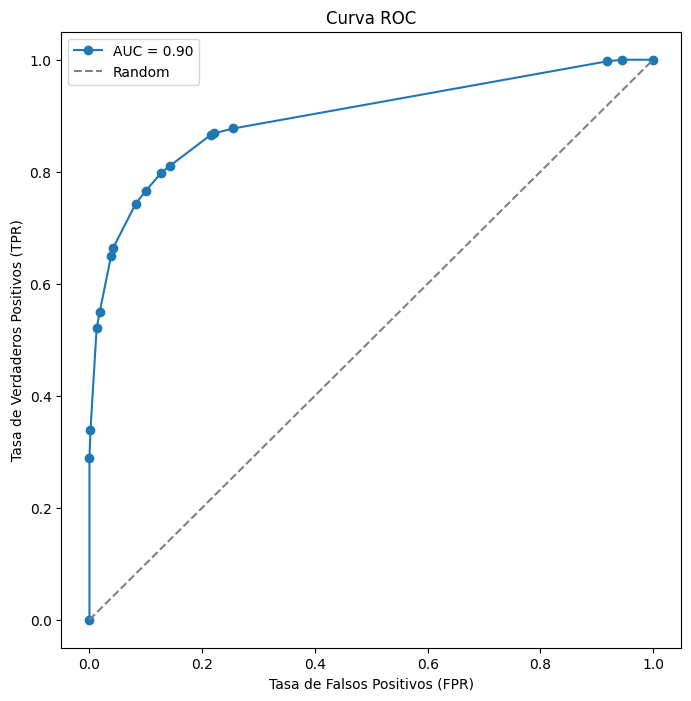

In [80]:
# Obtener las probabilidades predichas para las clases positivas
y_probabilities = best_tree_pipe.predict_proba(X)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y, y_probabilities)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y, y_probabilities)

# Visualizar la curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr,'o-', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend()
plt.show()

**Probabilidades Negativas**

<span style='color:peru'> Esto en general no se hace porque se sabe es la inversa de la anterior. Si usaramos el mismo criterio, en el caso por ejemplo de tres categorias se deberian hacer 6, sin embargo, se hacen 3 ya que las otras 3 son sus inversas.</span>  
  
<span style='color:peru'>De todas formas esta bueno para ver que no existe peor resultado que la linea 0-1 , puesto que si tuvieramos una curva por debajo de la linea se podrian invertir los resultados del modelo y obtendriamos una ROC mejor que la linea 0-1 que respresenta el azar.  
Conclusion: es FALSO (o por lo menos habria que aclararlo) que estar por debajo de la linea es peor (worst) que el azar, eso simplemente indica que el modelo esta entregando la valores opuestos para la clase. Lo peor es el azar que se representa por la linea 0-1.</span>

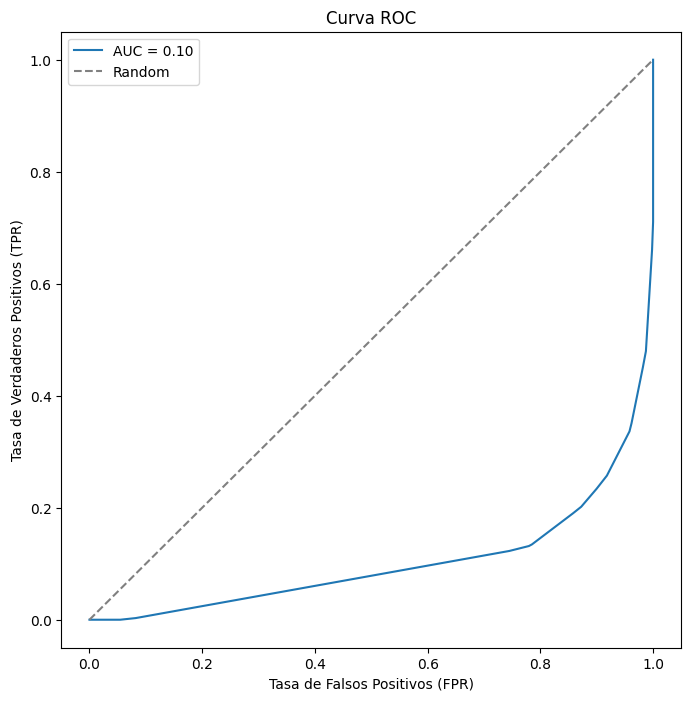

In [81]:
# Obtener las probabilidades predichas para las clases negativas
y_probabilities_neg = best_tree_pipe.predict_proba(X)[:, 0]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y, y_probabilities_neg)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y, y_probabilities_neg)

# Visualizar la curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend()
plt.show()

### Segundo caso Regresion Logistica utilizando Crossvalidation

In [82]:
# Inicializar el modelo de regresión logística
model = LogisticRegression()

# Crear un pipeline que incluya el escalado y el modelo
logistic_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logistic_regression", model)
])

# Definir los hiperparámetros a ajustar y sus posibles valores
param_grid = {
    'logistic_regression__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Valores de regularización C a probar
}

# Realizar la búsqueda de hiperparámetros mediante GridSearchCV
grid_search = GridSearchCV(logistic_pipe, param_grid=param_grid, cv=5, scoring='accuracy')

# Ajustar el modelo a los datos
grid_search.fit(X, y)

# Imprimir los mejores hiperparámetros y su precisión asociada
best_params = grid_search.best_params_
best_score = round(grid_search.best_score_, 2)

print("Mejores hiperparámetros:", best_params)
print("Precisión con mejores hiperparámetros:", best_score)

Mejores hiperparámetros: {'logistic_regression__C': 0.1}
Precisión con mejores hiperparámetros: 0.79


In [83]:
# Inicializar el modelo de regresión logística con los mejores hiperparámetros
best_logistic_model = LogisticRegression(C=0.1)

# Crear un pipeline que incluya el escalado y el modelo
best_logistic_pipe = Pipeline([
    ("scaler", StandardScaler()),  # Puedes omitir esto si no crees que el escalado sea necesario
    ("logistic_regression", best_logistic_model)
])

# Entrenar el modelo de regresión logística con todos los datos
best_logistic_pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression(C=0.1))])

In [84]:
# Realizar la validación cruzada de 5 pliegues con regresión logística
cross_val_scores_best_logistic = cross_val_score(best_logistic_pipe, X, y, cv=5, scoring='accuracy')

# Imprimir la media y la desviación estándar de las puntuaciones de validación cruzada
print(f"Media: {round(cross_val_scores_best_logistic.mean(), 2)}")
print(f"Desviación Estándar: {round(cross_val_scores_best_logistic.std(), 2)}")

Media: 0.79
Desviación Estándar: 0.01


**Probabilidades Positivas**

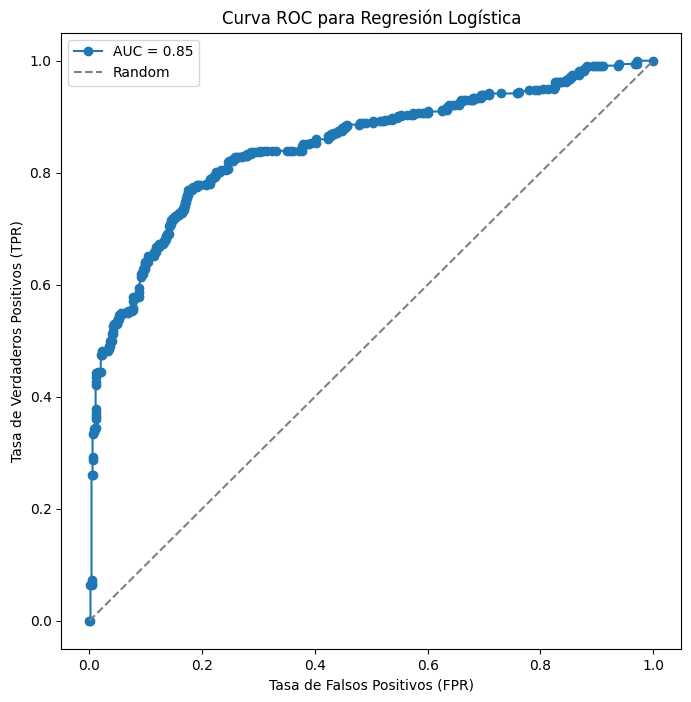

In [85]:
# Obtener las probabilidades predichas para las clases positivas con regresión logística
y_probabilities_logistic = best_logistic_pipe.predict_proba(X)[:, 1]

# Calcular la curva ROC
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y, y_probabilities_logistic)

# Calcular el área bajo la curva ROC (AUC)
roc_auc_logistic = roc_auc_score(y, y_probabilities_logistic)

# Visualizar la curva ROC para regresión logística
plt.figure(figsize=(8, 8))
plt.plot(fpr_logistic, tpr_logistic, 'o-',label=f'AUC = {roc_auc_logistic:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Curva ROC para Regresión Logística')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend()
plt.show()

**Probabilidades negativas**

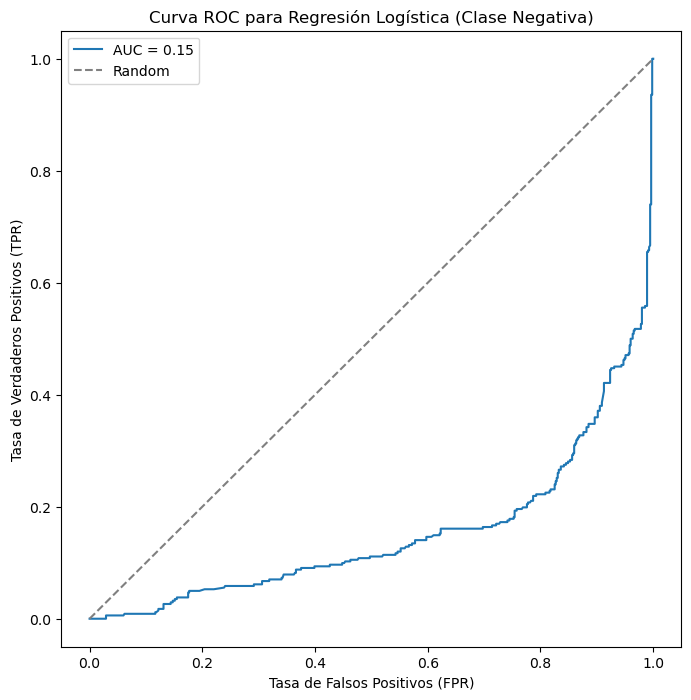

In [66]:
# Obtener las probabilidades predichas para las clases negativas con regresión logística
y_probabilities_neg_logistic = 1 - best_logistic_pipe.predict_proba(X)[:, 1]

# Calcular la curva ROC
fpr_logistic_neg, tpr_logistic_neg, thresholds_logistic_neg = roc_curve(y, y_probabilities_neg_logistic)

# Calcular el área bajo la curva ROC (AUC)
roc_auc_logistic_neg = roc_auc_score(y, y_probabilities_neg_logistic)

# Visualizar la curva ROC para regresión logística con probabilidades de clases negativas
plt.figure(figsize=(8, 8))
plt.plot(fpr_logistic_neg, tpr_logistic_neg, label=f'AUC = {roc_auc_logistic_neg:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Curva ROC para Regresión Logística (Clase Negativa)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend()
plt.show()

### Tercer caso KNN  utilizando Crossvalidation

In [67]:
# Inicializar el modelo de k-Nearest Neighbors
model_knn = KNeighborsClassifier()

# Crear un pipeline que incluya el escalado y el modelo
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", model_knn)
])

# Definir los hiperparámetros a ajustar y sus posibles valores
param_grid_knn = {
    'knn__n_neighbors': list(range(1, 10)),  # Valores de número de vecinos del 1 al 9
}

# Realizar la búsqueda de hiperparámetros mediante GridSearchCV
grid_search_knn = GridSearchCV(knn_pipe, param_grid=param_grid_knn, cv=5, scoring='accuracy')

# Ajustar el modelo a los datos
grid_search_knn.fit(X, y)

# Imprimir los mejores hiperparámetros y su precisión asociada
best_params_knn = grid_search_knn.best_params_
best_score_knn = round(grid_search_knn.best_score_, 2)

print("Mejores hiperparámetros:", best_params_knn)
print("Precisión con mejores hiperparámetros:", best_score_knn)

Mejores hiperparámetros: {'knn__n_neighbors': 4}
Precisión con mejores hiperparámetros: 0.82


In [68]:
# Inicializar el modelo de k-Nearest Neighbors con los mejores hiperparámetros
best_knn_model = KNeighborsClassifier(n_neighbors=4)  # Asegúrate de usar el mejor valor encontrado

# Crear un pipeline que incluya el escalado y el modelo de KNN
best_knn_pipe = Pipeline([
    ("scaler", StandardScaler()),  # Puedes omitir esto si no crees que el escalado sea necesario
    ("knn", best_knn_model)
])

# Entrenar el modelo de KNN con todos los datos
best_knn_pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=4))])

In [69]:
# Realizar la validación cruzada de 5 pliegues con k-Nearest Neighbors
cross_val_scores_best_knn = cross_val_score(best_knn_pipe, X, y, cv=5, scoring='accuracy')

# Imprimir la media y la desviación estándar de las puntuaciones de validación cruzada con KNN
print(f"Media: {round(cross_val_scores_best_knn.mean(), 2)}")
print(f"Desviación Estándar: {round(cross_val_scores_best_knn.std(), 2)}")


Media: 0.82
Desviación Estándar: 0.01


**Probabilidades Positivas**

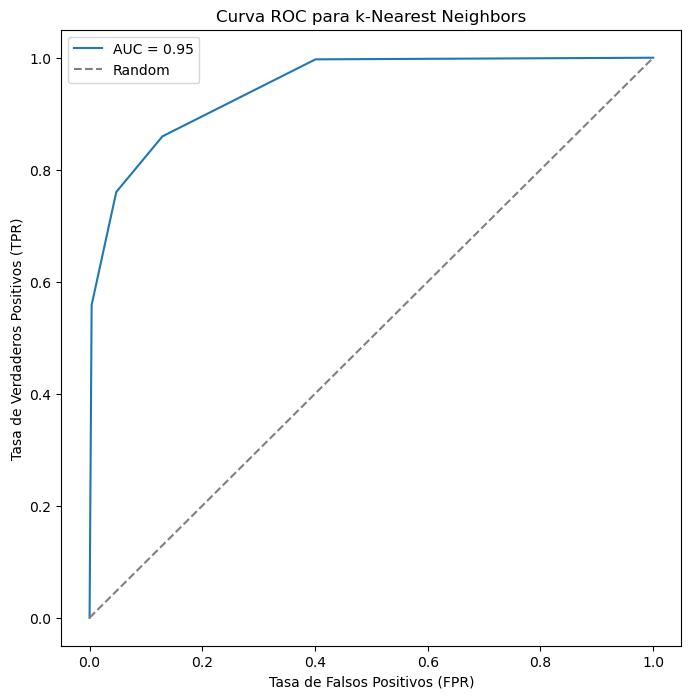

In [70]:
# Obtener las probabilidades predichas para las clases positivas con k-Nearest Neighbors
y_probabilities_knn = best_knn_pipe.predict_proba(X)[:, 1]

# Calcular la curva ROC
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y, y_probabilities_knn)

# Calcular el área bajo la curva ROC (AUC)
roc_auc_knn = roc_auc_score(y, y_probabilities_knn)

# Visualizar la curva ROC para k-Nearest Neighbors
plt.figure(figsize=(8, 8))
plt.plot(fpr_knn, tpr_knn, label=f'AUC = {roc_auc_knn:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Curva ROC para k-Nearest Neighbors')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend()
plt.show()


**Probabilidades negativas**

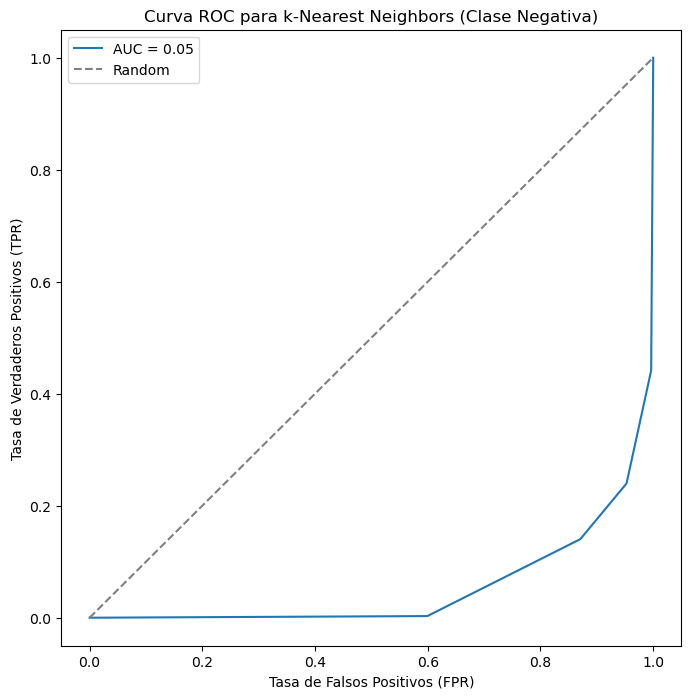

In [71]:
# Obtener las probabilidades predichas para las clases negativas con k-Nearest Neighbors
y_probabilities_neg_knn = 1 - best_knn_pipe.predict_proba(X)[:, 1]

# Calcular la curva ROC
fpr_knn_neg, tpr_knn_neg, thresholds_knn_neg = roc_curve(y, y_probabilities_neg_knn)

# Calcular el área bajo la curva ROC (AUC)
roc_auc_knn_neg = roc_auc_score(y, y_probabilities_neg_knn)

# Visualizar la curva ROC para k-Nearest Neighbors con probabilidades de clases negativas
plt.figure(figsize=(8, 8))
plt.plot(fpr_knn_neg, tpr_knn_neg, label=f'AUC = {roc_auc_knn_neg:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Curva ROC para k-Nearest Neighbors (Clase Negativa)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend()
plt.show()


### Cuarto caso Random Forest utilizando Crossvalidation

In [73]:
# Inicializar el modelo de Random Forest
model_rf = RandomForestClassifier()

# Crear un pipeline que incluya el escalado y el modelo
rf_pipe = Pipeline([
    ("scaler", StandardScaler()),  # Puedes omitir esto si no crees que el escalado sea necesario
    ("random_forest", model_rf)
])

# Definir los hiperparámetros a ajustar y sus posibles valores
param_grid_rf = {
    'random_forest__n_estimators': [50, 100, 150],  # Número de árboles en el bosque
    'random_forest__max_depth': [None, 10, 20, 30],  # Profundidad máxima de cada árbol
}

# Realizar la búsqueda de hiperparámetros mediante GridSearchCV
grid_search_rf = GridSearchCV(rf_pipe, param_grid=param_grid_rf, cv=5, scoring='accuracy')

# Ajustar el modelo a los datos
grid_search_rf.fit(X, y)

# Imprimir los mejores hiperparámetros y su precisión asociada
best_params_rf = grid_search_rf.best_params_
best_score_rf = round(grid_search_rf.best_score_, 2)

print("Mejores hiperparámetros:", best_params_rf)
print("Precisión con mejores hiperparámetros:", best_score_rf)

Mejores hiperparámetros: {'random_forest__max_depth': 10, 'random_forest__n_estimators': 100}
Precisión con mejores hiperparámetros: 0.84


In [74]:
# Inicializar el modelo de Random Forest con los mejores hiperparámetros
best_rf_model = RandomForestClassifier(max_depth=10, n_estimators=100)  # Asegúrate de usar los mejores valores encontrados

# Crear un pipeline que incluya el escalado y el modelo de Random Forest
best_rf_pipe = Pipeline([
    ("scaler", StandardScaler()),  # Puedes omitir esto si no crees que el escalado sea necesario
    ("random_forest", best_rf_model)
])

# Entrenar el modelo de Random Forest con todos los datos
best_rf_pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('random_forest', RandomForestClassifier(max_depth=10))])

In [75]:
# Realizar la validación cruzada de 5 pliegues con Random Forest
cross_val_scores_best_rf = cross_val_score(best_rf_pipe, X, y, cv=5, scoring='accuracy')

# Imprimir la media y la desviación estándar de las puntuaciones de validación cruzada con Random Forest
print(f"Media: {round(cross_val_scores_best_rf.mean(), 2)}")
print(f"Desviación Estándar: {round(cross_val_scores_best_rf.std(), 2)}")


Media: 0.84
Desviación Estándar: 0.03


**Probabilidades Positivas**

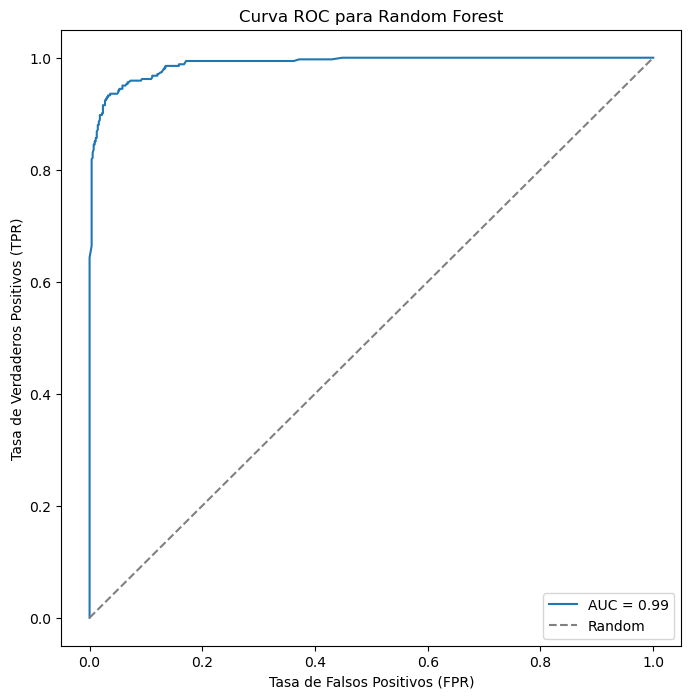

In [76]:
# Obtener las probabilidades predichas para las clases positivas con Random Forest
y_probabilities_rf = best_rf_pipe.predict_proba(X)[:, 1]

# Calcular la curva ROC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y, y_probabilities_rf)

# Calcular el área bajo la curva ROC (AUC)
roc_auc_rf = roc_auc_score(y, y_probabilities_rf)

# Visualizar la curva ROC para Random Forest
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {roc_auc_rf:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Curva ROC para Random Forest')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend()
plt.show()


**Probabilidades negativas**

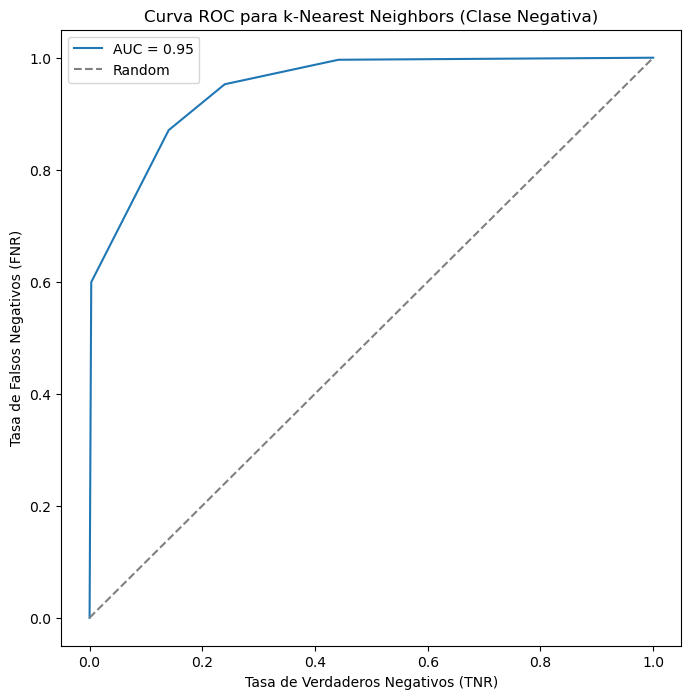

In [77]:
# Obtener las probabilidades predichas para las clases negativas con k-Nearest Neighbors
y_probabilities_neg_knn = 1 - best_knn_pipe.predict_proba(X)[:, 1]

# Calcular la curva ROC para la clase negativa
fpr_knn_neg, tpr_knn_neg, thresholds_knn_neg = roc_curve(1 - y, y_probabilities_neg_knn)

# Calcular el área bajo la curva ROC (AUC) para la clase negativa
roc_auc_knn_neg = roc_auc_score(1 - y, y_probabilities_neg_knn)

# Visualizar la curva ROC para k-Nearest Neighbors con probabilidades de clases negativas
plt.figure(figsize=(8, 8))
plt.plot(fpr_knn_neg, tpr_knn_neg, label=f'AUC = {roc_auc_knn_neg:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Curva ROC para k-Nearest Neighbors (Clase Negativa)')
plt.xlabel('Tasa de Verdaderos Negativos (TNR)')
plt.ylabel('Tasa de Falsos Negativos (FNR)')
plt.legend()
plt.show()


<span style='color:peru'> Aca se puede ver como un target balanceado da la posibilidad de tener más umbrales significactivos (que dan valores diferentes de fpr-tpr) y por lo tanto una ROC mas "suave" y "completa".</span>